We will be using pvlib for this particular calculations.

In [17]:
import pandas as pd
import pvlib
time = pd.date_range(start='2015', end='2021', freq='1H')
location = pvlib.location.Location(27.92470360190826, 84.73285907464792)
solar_position = location.get_solarposition(time)
atmospheric_data = location.get_clearsky(time)
atmospheric_data.to_csv('ab.csv')

In [18]:
df=pd.read_csv('ab.csv')
df.rename(columns={df.columns[0]:'Time'},inplace=1)
print(df.columns)
df.to_csv('ab.csv')

Index(['Time', 'ghi', 'dni', 'dhi'], dtype='object')


In [19]:
import pandas as pd
import pvlib
from pvlib import location
from pvlib import irradiance
import datetime

df=pd.read_csv('ab.csv')
df.rename(columns={df.columns[0]:'Time'},inplace=1)



# Load weather data from CSV
weather = pd.read_csv('ab.csv')
weather['Time'] = pd.to_datetime(weather['Time'])
weather.set_index('Time', inplace=True)

# Specify constants
latitude, longitude, tz = 27.92470360190826, 84.73285907464792, 'Asia/Kathmandu'
surface_tilt = 19
surface_azimuth = 180  # PV facing south

# Create location object
site = location.Location(latitude, longitude, tz=tz)

# Calculate solar position
solpos = site.get_solarposition(weather.index)


# Calculate POA irradiance
poa_irradiance = irradiance.get_total_irradiance(
    surface_tilt,
    surface_azimuth,
    solpos['apparent_zenith'],
    solpos['azimuth'],
    weather['dni'],
    weather['ghi'],
    weather['dhi'],
    model='isotropic'
)

# The DataFrame 'poa_irradiance' now contains the POA irradiance data
# print(poa_irradiance)
poa_irradiance.to_csv('total_solar.csv')




In [20]:
df=pd.read_csv('total_solar.csv')
df.rename(columns={'Time':'time'},inplace=True)
df.to_csv('total_solar.csv')
df.drop('poa_direct',axis=1,inplace=True)
df.drop('poa_diffuse',axis=1,inplace=True)
df.drop('poa_sky_diffuse',axis=1,inplace=True)
df.drop('poa_ground_diffuse',axis=1,inplace=True)
df.rename(columns={'poa_global':'It'},inplace=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print(df.columns)
df.to_csv('POA.csv')

Index(['time', 'It'], dtype='object')


In [21]:
Area=49.8*10**6
Area_eff=0.4*Area
efficiency=0.18
Tpanel=48
NOCT=48


In [22]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': '2m_temperature',
        'year': ['2015','2016','2017','2018','2019','2020'],
        'month': ['01', '02','03','04','05','06','07','08','09','10','11','12'],
        'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'],
        'time': ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00'],
        'area': [27.92470360190826, 84.73285907464792,27.92470360190826, 84.73285907464792]
    },
    'download.nc')



2024-01-27 10:08:56,663 INFO Welcome to the CDS
2024-01-27 10:08:56,663 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-01-27 10:08:56,907 INFO Request is queued
2024-01-27 11:50:01,734 INFO Request is running
2024-01-27 13:30:45,293 INFO Request is completed
2024-01-27 13:30:45,308 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data6/adaptor.mars.internal-1706340434.00775-12354-18-34c233b1-0424-47ff-958d-96be0628a9ac.nc to download.nc (309.3K)
2024-01-27 13:30:47,517 INFO Download rate 140.3K/s


Result(content_length=316728,content_type=application/x-netcdf,location=https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data6/adaptor.mars.internal-1706340434.00775-12354-18-34c233b1-0424-47ff-958d-96be0628a9ac.nc)

In [23]:
import xarray as xr

# Open the NetCDF file
ds = xr.open_dataset('download.nc')
import pandas as pd

# Convert the xarray Dataset to a pandas DataFrame
df = ds.to_dataframe()

# Reset the index of the DataFrame
df.reset_index(inplace=True)

# Write the DataFrame to a CSV file
df.to_csv('temperature_data.csv', index=False)





In [24]:
df=pd.read_csv('temperature_data.csv')
print(df.columns)
df.drop('longitude',axis=1,inplace=True)
df.drop('latitude',axis=1,inplace=True)
df.rename(columns={'t2m':'temperature'},inplace=True)
df.temperature=(df.temperature-273)
print(df.columns)
df.to_csv('temperature1.csv')

Index(['longitude', 'latitude', 'time', 't2m'], dtype='object')
Index(['time', 'temperature'], dtype='object')


In [25]:
# Read the two CSV files into two separate DataFrames
df1 = pd.read_csv('POA.csv')
df2 = pd.read_csv('temperature1.csv')

# Merge the two DataFrames on the 'date' column
merged_df = pd.merge(df1, df2, on='time')

# Reorder the columns
merged_df = merged_df[['time', 'It', 'temperature']]

# Write the merged DataFrame to a new CSV file
merged_df.to_csv('uttarganga.csv', index=False)


In [26]:
import pandas as pd
df=pd.read_csv('uttarganga.csv')
print(df.columns)

Index(['time', 'It', 'temperature'], dtype='object')


In [27]:
Tpanel=df.temperature+((48-20)*df.It)/800

In [28]:
Epv=df.It*Area_eff*efficiency*(1-0.05*(df.temperature-25)*(Tpanel-25)*0.78/100)

In [29]:
# Add new columns to the DataFrame
df['Tpanel'] = Tpanel
df['Epv'] = Epv

# Save the DataFrame to a CSV file
df.to_csv('uttarganga.csv', index=False)


In [30]:
import matplotlib.pyplot as plt

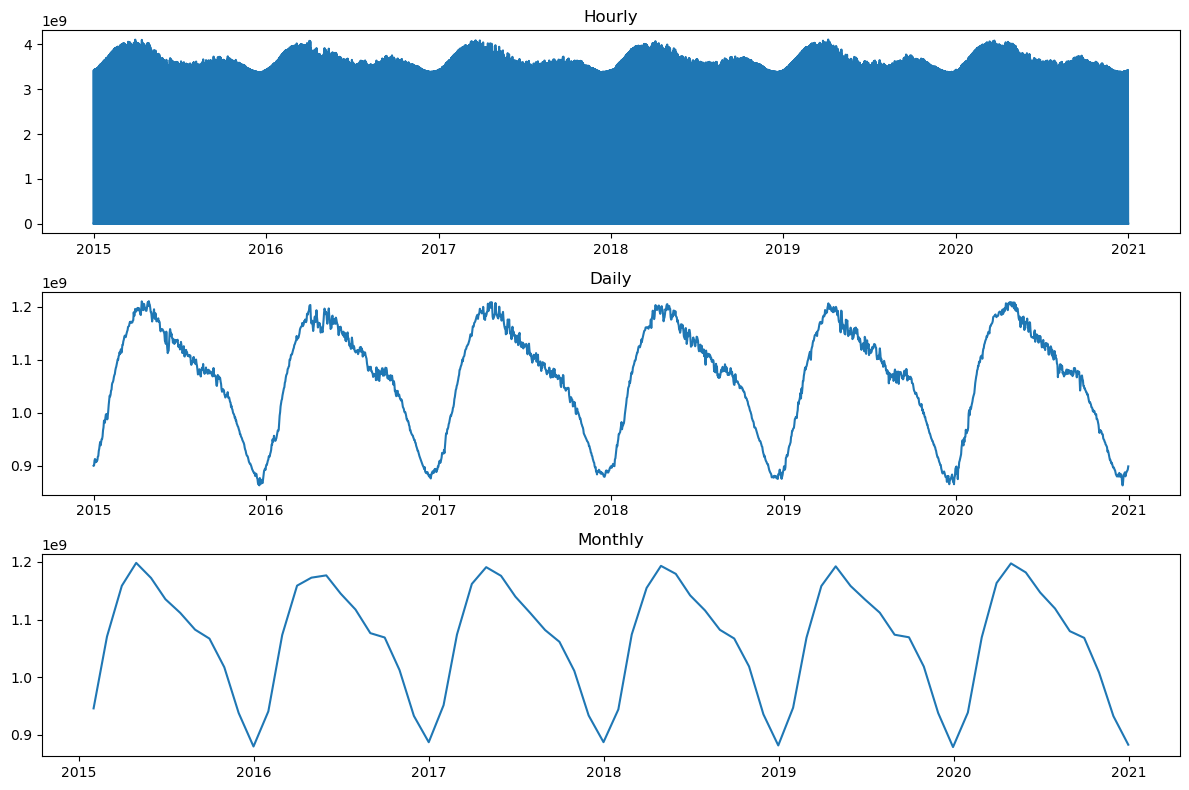

In [31]:
import matplotlib.pyplot as plt

# Convert the 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Set 'time' as the index of the DataFrame
df.set_index('time', inplace=True)

# Create hourly, daily, and monthly DataFrames
df_hourly = df.resample('H').mean()
df_daily = df.resample('D').mean()
df_monthly = df.resample('M').mean()

# Plot the 'Epv' column for each DataFrame
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(df_hourly.index, df_hourly['Epv'])
plt.title('Hourly')

plt.subplot(3, 1, 2)
plt.plot(df_daily.index, df_daily['Epv'])
plt.title('Daily')

plt.subplot(3, 1, 3)
plt.plot(df_monthly.index, df_monthly['Epv'])
plt.title('Monthly')

plt.tight_layout()
plt.show()


In [32]:
df=pd.read_csv('uttarganga.csv')
df.Epv.max()/10**6

4108.718551342688